# import

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import kstest, gaussian_kde, ks_2samp, chi2_contingency
from scipy.spatial.distance import jensenshannon
# from table_evaluator import load_data, TableEvaluator
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split

In [2]:
set_verbosity(ERROR)

# load data

In [3]:
# folder_path = 'gtfs'

# agency = pd.read_csv(f'{folder_path}/agency.txt')
# calendar = pd.read_csv(f'{folder_path}/calendar.txt')
# calendar_dates = pd.read_csv(f'{folder_path}/calendar_dates.txt')
# fare_attributes = pd.read_csv(f'{folder_path}/fare_attributes.txt')
# fare_rules = pd.read_csv(f'{folder_path}/fare_rules.txt')
# feed_info = pd.read_csv(f'{folder_path}/feed_info.txt')
# frequencies = pd.read_csv(f'{folder_path}/frequencies.txt')
# routes = pd.read_csv(f'{folder_path}/routes.txt')
# shapes = pd.read_csv(f'{folder_path}/shapes.txt')
# stops = pd.read_csv(f'{folder_path}/stops.txt')
# stop_times = pd.read_csv(f'{folder_path}/stop_times.txt')
# transfers = pd.read_csv(f'{folder_path}/transfers.txt')
# trips = pd.read_csv(f'{folder_path}/trips.txt')

In [4]:
# join map
# # Read GTFS CSV files
# agency = pd.read_csv('gtfs/agency.txt')
# stops = pd.read_csv('gtfs/stops.txt')
# routes = pd.read_csv('gtfs/routes.txt')
# trips = pd.read_csv('gtfs/trips.txt')
# stop_times = pd.read_csv('gtfs/stop_times.txt')
# calendar = pd.read_csv('gtfs/calendar.txt')
# routes_agency = routes.merge(agency, on='agency_id', how='left')
# trips_routes = trips.merge(routes_agency, on='route_id', how='left')
# stop_times_trips = stop_times.merge(trips_routes, on='trip_id', how='left')
# stop_times_trips_stops = stop_times_trips.merge(stops, on='stop_id', how='left')
# trips_calendar = trips.merge(calendar, on='service_id', how='left')
# joined_data = stop_times_trips_stops.merge(trips_calendar, on=['trip_id', 'route_id', 'service_id'], how='left', suffixes=('', '_y'))
# joined_data = joined_data.loc[:, ~joined_data.columns.str.endswith('_y')]
# joined_data.head()

In [5]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [6]:
# def preprocess(data_collection):
    # for k, v in data_collection.items():
    #     current_data = v.select_dtypes(include=[np.number]).astype(np.float32)
    #     scaler = StandardScaler()
    #     data_collection[k] = scaler.fit_transform(current_data)
    # return data_collection

In [7]:
real_data_collection = load_data_collection("gtfs")

In [8]:
del real_data_collection['shapes']

# preprocess

In [9]:
def individual_preprocess_dict():
    preprocess_dict = {}
    preprocess_dict['transformation'] = {}
    preprocess_dict['transformation']['drop'] = []
    preprocess_dict['transformation']['factorize'] = []
    preprocess_dict['transformation']['to_strip'] = []
    preprocess_dict['transformation']['to_elapsed_time'] = []
    preprocess_dict['transformation']['to_elapsed_days'] = []
    preprocess_dict['nans_conversion'] = {}
    preprocess_dict['nans_conversion']['impute'] = []
    preprocess_dict['nans_conversion']['replace_with_neg_one'] = []
    preprocess_dict['nans_conversion']['replace_with_zeros'] = []
    return preprocess_dict

In [10]:
def format_individual_data(data, preprocess_dict, timestamp = pd.Timestamp('1900-01-01')):
    # reverse_transform_dict = {}
    for stage in preprocess_dict.keys():
        if stage == 'transformation':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'drop':
                        data = data.drop(col_list, axis=1)
                    if method == 'factorize':
                        for col in col_list:
                            data[col] = pd.factorize(data[col])[0]
                    if method == 'to_strip':
                        for col in col_list:
                            # convert some column to numbers
                            # e.g. `123-45-6` -> `123456`
                            data[col] = data[col].str.replace(r'\D', '').astype(int)
                    if method == "to_elapsed_time":
                        for col in col_list:
                            cur_col = pd.to_timedelta(data[col])
                            cur_col = cur_col % pd.Timedelta(days=1)
                            data[col] = cur_col.dt.total_seconds()
                    if method == "to_elapsed_days":
                        for col in col_list:
                            cur_col = pd.to_datetime(data[col], format='%Y%m%d') - timestamp
                            data[col] = cur_col.dt.days
        if stage == 'nans_conversion':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'impute':
                        imputer = SimpleImputer(strategy='mean')
                        data[col_list] = imputer.fit_transform(data[col_list])
                    if method == 'replace_with_neg_one':
                        data[col_list] = data[col_list].fillna(-1)
                    if method == 'replace_with_zeros':
                        data[col_list] = data[col_list].fillna(0)
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaled_data = scaler.fit_transform(data)
    return data

## preprocess individual data

### agency

In [11]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['agency_name','agency_fare_url','agency_email']
preprocess_dict['transformation']['factorize'] = ['agency_id','agency_url','agency_timezone','agency_lang','agency_phone']
real_data_collection['agency'] = format_individual_data(real_data_collection['agency'], preprocess_dict)

### calendar

In [12]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
real_data_collection['calendar'] = format_individual_data(real_data_collection['calendar'], preprocess_dict)

### calendar_dates

In [13]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['date']
real_data_collection['calendar_dates'] = format_individual_data(real_data_collection['calendar_dates'], preprocess_dict)

### routes

In [14]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['route_short_name','route_long_name','route_desc','route_url','route_sort_order']
preprocess_dict['transformation']['factorize'] = ['route_id',
                                                  'agency_id',
                                                 'route_color',
                                                 'route_text_color',
                                                 'contract_id']
preprocess_dict['nans_conversion']['impute'] = ['route_color','route_text_color']
real_data_collection['routes'] = format_individual_data(real_data_collection['routes'], preprocess_dict)

### stops

In [15]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['stop_id','parent_station','platform_code']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
preprocess_dict['transformation']['drop'] = ['stop_name','stop_code','stop_desc','zone_id','stop_url','stop_timezone']
preprocess_dict['nans_conversion']['impute'] = ['parent_station','platform_code']
real_data_collection['stops'] = format_individual_data(real_data_collection['stops'], preprocess_dict)

### stop_times

In [16]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['trip_id','stop_id','stop_headsign']
preprocess_dict['transformation']['to_elapsed_time'] = ['arrival_time','departure_time']
real_data_collection['stop_times'] = format_individual_data(real_data_collection['stop_times'], preprocess_dict)

### trips

In [17]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['route_id','service_id','trip_id','trip_headsign','shape_id']
preprocess_dict['transformation']['drop'] = ['trip_short_name','block_id']
real_data_collection['trips'] = format_individual_data(real_data_collection['trips'], preprocess_dict)

## Create Metadata

In [18]:
def auto_detect_relation(data_collection):
    metadata = {}
    for df_name, df in data_collection.items():
        parent = {}
        child = []
        primary_key = []
        foreign_key = []
        for col in df.columns:
            if 'id' in col:
                if df[col].nunique() == len(df):
                    primary_key = [col, len(df)]
                else:
                    foreign_key.append(col)
        for foreign_df_name, foreign_df in data_collection.items():
            if foreign_df_name != df_name:
                for col in foreign_df.columns:
                    if 'id' in col:
                        for fr_k in foreign_key:
                            if col == fr_k and foreign_df[col].nunique() == len(foreign_df):
                                parent[foreign_df_name] = fr_k
                        if primary_key != []:
                            if col == primary_key[0] and foreign_df[col].nunique() != len(foreign_df):
                                child.append(foreign_df_name)
        metadata[df_name] = {'primary_key':primary_key,
                             'parent':parent,
                             'child':child}
    return metadata

In [19]:
metadata = auto_detect_relation(real_data_collection)

In [20]:
metadata

{'agency': {'primary_key': ['agency_id', 15],
  'parent': {},
  'child': ['routes']},
 'calendar': {'primary_key': ['service_id', 121],
  'parent': {},
  'child': ['calendar_dates', 'trips']},
 'calendar_dates': {'primary_key': [],
  'parent': {'calendar': 'service_id'},
  'child': []},
 'routes': {'primary_key': ['route_id', 215],
  'parent': {'agency': 'agency_id'},
  'child': ['trips']},
 'stops': {'primary_key': ['stop_id', 6714],
  'parent': {},
  'child': ['stop_times']},
 'stop_times': {'primary_key': [],
  'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
  'child': []},
 'trips': {'primary_key': ['trip_id', 32403],
  'parent': {'calendar': 'service_id', 'routes': 'route_id'},
  'child': ['stop_times']}}

## Scaling

In [21]:
def scale_individual_df(df):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [22]:
def extract_key_and_scaled_features(df, label_columns):
    labels = df[label_columns]
    table = df.drop(columns=label_columns)
    table_column_names = table.columns
    scaled_table, table_scaler = scale_individual_df(table)
    return scaled_table, labels, table_scaler, table_column_names

In [23]:
def batch_preprocessing(data_collection, metadata):
    processed_data_collection = {}
    for df_name, df in data_collection.items():
        primary_key = []
        foreign_key = []
        if metadata[df_name]['primary_key'] != []:
            primary_key = [metadata[df_name]['primary_key'][0]]
        if metadata[df_name]['parent'] != {}:
            foreign_key = list(metadata[df_name]['parent'].values())
        label_columns = primary_key + foreign_key
        table, labels, table_scaler, table_columns = extract_key_and_scaled_features(df, label_columns)
        processed_data_collection[df_name] = {'table':table,
                                              'labels':labels,
                                              'table_scaler':table_scaler,
                                              'table_col_names':table_columns,
                                              'label_col_names':label_columns,
                                             'metadata':metadata[df_name]}
    return processed_data_collection

In [24]:
processed_data_collection = batch_preprocessing(real_data_collection, metadata)
del real_data_collection

# GAN Building

## Additional Custom Function (Wasserstein Loss)

In [25]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

In [26]:
class ClipConstraint(constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

## Define Plotting Function For G/D Loss

In [27]:
import matplotlib.pyplot as plt

def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (model_name, generator_log, discriminator_log) in enumerate(logs):
        axes[i].plot(generator_log, label='gen')
        axes[i].plot(discriminator_log, label='d')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

## (!) Define Main Generator, Discriminator

In [28]:
def build_generator(table_dim, labels_dim, latent_dim=100):
    noise_input = layers.Input(shape=(latent_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([noise_input, labels_input])
    bn_layer1 = layers.BatchNormalization()(merge_input)
    hidden_layer1 = layers.Dense(256,activation='LeakyReLU')(bn_layer1)
    hidden_layer2 = layers.Dense(512,activation='LeakyReLU')(hidden_layer1)
    hidden_layer3 = layers.Dense(1024,activation='LeakyReLU')(hidden_layer2)
    bn_layer2 = layers.BatchNormalization()(hidden_layer3)
    output_layer = layers.Dense(table_dim, activation='sigmoid')(bn_layer2)
    generator = models.Model([noise_input, labels_input], output_layer)
    return generator

In [29]:
# def build_generator(table_dim, labels_dim, latent_dim=100):
#     noise_input = layers.Input(shape=(latent_dim,))
#     labels_input = layers.Input(shape=(labels_dim,))
#     merge_input = layers.Concatenate()([noise_input, labels_input])
#     bn_layer1 = layers.BatchNormalization()(merge_input)
#     hidden_layer1 = layers.Dense(128,activation='LeakyReLU')(bn_layer1)
#     reshape_layer = layers.Reshape((4, 32))(hidden_layer1)
#     conv1 = layers.Conv1DTranspose(128,
#                           kernel_size=4,
#                           strides=2,
#                           padding="same",
#                           activation="LeakyReLU")(reshape_layer)
#     conv2 = layers.Conv1DTranspose(128,
#                           kernel_size=4,
#                           strides=2,
#                           padding="same",
#                           activation="LeakyReLU")(conv1)
#     conv3 = layers.Conv1DTranspose(128,
#                           kernel_size=4,
#                           strides=2,
#                           padding="same",
#                           activation="LeakyReLU")(conv2)
#     bn_layer2 = layers.BatchNormalization()(conv3)
#     output_layer = layers.Dense(table_dim, activation='sigmoid')(bn_layer2)
#     generator = models.Model([noise_input, labels_input], output_layer)
#     return generator

In [30]:
# def build_discriminator(table_dim, labels_dim, constraint_rate=0.01, optimization_rate=0.00005):
#     clip_const = ClipConstraint(constraint_rate)
#     rms_opt = optimizers.RMSprop(optimization_rate)
#     table_input = layers.Input(shape=(table_dim,))
#     labels_input = layers.Input(shape=(labels_dim,))
#     merge_input = layers.Concatenate()([table_input, labels_input])
#     bn_layer1 = layers.BatchNormalization()(merge_input)
#     hidden_layer1 = layers.Dense(512,activation='LeakyReLU',kernel_constraint=clip_const)(bn_layer1)
#     hidden_layer2 = layers.Dense(256,activation='LeakyReLU',kernel_constraint=clip_const)(hidden_layer1)
#     hidden_layer3 = layers.Dense(128,activation='LeakyReLU',kernel_constraint=clip_const)(hidden_layer2)
#     bn_layer2 = layers.BatchNormalization()(hidden_layer3)
#     output_layer = layers.Dense(1, activation='sigmoid')(bn_layer2)
#     discriminator = models.Model([table_input, labels_input], output_layer)
#     discriminator.compile(loss=wasserstein_loss, optimizer=rms_opt, metrics=['accuracy'])
#     return discriminator

In [31]:
def build_discriminator(table_dim, labels_dim, constraint_rate=0.01, optimization_rate=0.00005):
    clip_const = ClipConstraint(constraint_rate)
    rms_opt = optimizers.RMSprop(optimization_rate)
    table_input = layers.Input(shape=(table_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([table_input, labels_input])
    bn_layer1 = layers.BatchNormalization()(merge_input)
    hidden_layer1 = layers.Dense(256,activation='LeakyReLU')(bn_layer1)
    reshape_layer = layers.Reshape((4, 64))(hidden_layer1)
    conv1 = layers.Conv1D(128,
                          kernel_size=4,
                          strides=2,
                          padding="same",
                          kernel_constraint=clip_const,
                          activation="LeakyReLU")(reshape_layer)
    conv2 = layers.Conv1D(64,
                          kernel_size=4,
                          strides=2,
                          padding="same",
                          kernel_constraint=clip_const,
                          activation="LeakyReLU")(conv1)
    conv3 = layers.Conv1D(32,
                          kernel_size=4,
                          strides=2,
                          padding="same",
                          kernel_constraint=clip_const,
                          activation="LeakyReLU")(conv2)
    bn_layer2 = layers.BatchNormalization()(conv3)
    output_layer = layers.Dense(1, activation='sigmoid')(bn_layer2)
    discriminator = models.Model([table_input, labels_input], output_layer)
    discriminator.compile(loss=wasserstein_loss, optimizer=rms_opt, metrics=['accuracy'])
    return discriminator

In [32]:
def build_gan(generator, discriminator, optimization_rate=0.00005):
    discriminator.trainable = False
    rms_opt = optimizers.RMSprop(optimization_rate)
    noise_input = layers.Input(shape=(generator.input_shape[0][1],))
    labels_input = layers.Input(shape=(generator.input_shape[1][1],))
    generator_output = generator([noise_input, labels_input])
    discriminator_output = discriminator([generator_output, labels_input])
    gan = models.Model(inputs=[noise_input, labels_input], outputs=discriminator_output)
    gan.compile(optimizer=rms_opt, loss=wasserstein_loss)
    return gan

## Define Training Strategy

In [33]:
def train_individual_gan(name, real_table, real_labels, epochs=50, batch_size=128, latent_dim=100, seed=123, return_logs=True):
    rand_seed = seed
    class_counts = real_labels.nunique().tolist()
    generator = build_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    discriminator = build_discriminator(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, discriminator)
    
    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        discriminator_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        rand_seed ++1
        start_time = time.time()
        idx = np.random.randint(0, real_table.shape[0], batch_size)
        noise = np.random.uniform(0, 1, (batch_size, latent_dim))
        
        x_real_labels = real_labels.iloc[idx]
        x_real_table = real_table.iloc[idx]
        # x_fake_labels = np.random.uniform(0, 1, (batch_size, real_labels.shape[1]))
        x_fake_labels = np.column_stack([np.random.randint(0, class_counts, size=batch_size) for class_counts in class_counts])
        x_fake_table = generator.predict([noise, x_fake_labels])
        
        d_loss_real, _ = discriminator.train_on_batch([x_real_table, x_real_labels], y_real)
        d_loss_fake, _ = discriminator.train_on_batch([x_fake_table, x_fake_labels], y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        g_loss = gan.train_on_batch([noise, x_fake_labels], y_real)
        
        if return_logs:
            generator_logs.append(g_loss)
            discriminator_logs.append(d_loss)
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if epoch % 10 == 0 or epoch == epochs-1:
            print(f"[Epoch: {epoch}] [D loss: {np.round(d_loss, 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
    generator.save('models/'+name+'_gan.h5')
    
    if return_logs:
        return generator_logs, discriminator_logs

In [34]:
def collection_training(data_collection, training_parameter_dict):
    logs = []
    init_time = time.time()
    for df_name, content in data_collection.items():
        start_time = time.time()
        print(f'Learning \"{df_name}\" data......')
        generator_log, discriminator_log = train_individual_gan(df_name,
                                                                  content['table'],
                                                                  content['labels'],
                                                                epochs=training_parameter_dict[df_name]['epochs'],
                                                                  return_logs=True)
        in_loop_elapsed_time = time.time() - start_time
        minutes, seconds = divmod(in_loop_elapsed_time, 60)
        print("Time Used: %dm %ds" % (minutes, seconds))
        print('.')
        print('.')
        logs.append([df_name, generator_log, discriminator_log])
    plot_history(logs)
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [35]:
training_parameter_dict = {}
for df_name, content in processed_data_collection.items():
    nrows = content['table'].shape[0]
    # training_parameter_dict[df_name] = {'epochs':500}
    if nrows <= 100:
        training_parameter_dict[df_name] = {'epochs':25}
    elif nrows <= 10000:
        training_parameter_dict[df_name] = {'epochs':25}
    else:
        training_parameter_dict[df_name] = {'epochs':25}

In [36]:
training_parameter_dict

{'agency': {'epochs': 25},
 'calendar': {'epochs': 25},
 'calendar_dates': {'epochs': 25},
 'routes': {'epochs': 25},
 'stops': {'epochs': 25},
 'stop_times': {'epochs': 25},
 'trips': {'epochs': 25}}

Learning "agency" data......
[Epoch: 0] [D loss: 0.25] [G loss: 0.5] [Speed: 0.2 it/s]
[Epoch: 10] [D loss: 0.249] [G loss: 0.498] [Speed: 13.33 it/s]
[Epoch: 20] [D loss: 0.248] [G loss: 0.496] [Speed: 13.33 it/s]
[Epoch: 24] [D loss: 0.248] [G loss: 0.496] [Speed: 13.33 it/s]
Time Used: 0m 9s
.
.
Learning "calendar" data......
[Epoch: 0] [D loss: 0.249] [G loss: 0.5] [Speed: 0.49 it/s]
[Epoch: 10] [D loss: 0.249] [G loss: 0.498] [Speed: 11.63 it/s]
[Epoch: 20] [D loss: 0.248] [G loss: 0.496] [Speed: 10.87 it/s]
[Epoch: 24] [D loss: 0.248] [G loss: 0.496] [Speed: 10.99 it/s]
Time Used: 0m 4s
.
.
Learning "calendar_dates" data......
[Epoch: 0] [D loss: 0.249] [G loss: 0.5] [Speed: 0.46 it/s]
[Epoch: 10] [D loss: 0.249] [G loss: 0.498] [Speed: 9.17 it/s]
[Epoch: 20] [D loss: 0.248] [G loss: 0.497] [Speed: 9.52 it/s]
[Epoch: 24] [D loss: 0.248] [G loss: 0.496] [Speed: 9.8 it/s]
Time Used: 0m 4s
.
.
Learning "routes" data......
[Epoch: 0] [D loss: 0.251] [G loss: 0.5] [Speed: 0.47 it/s]
[

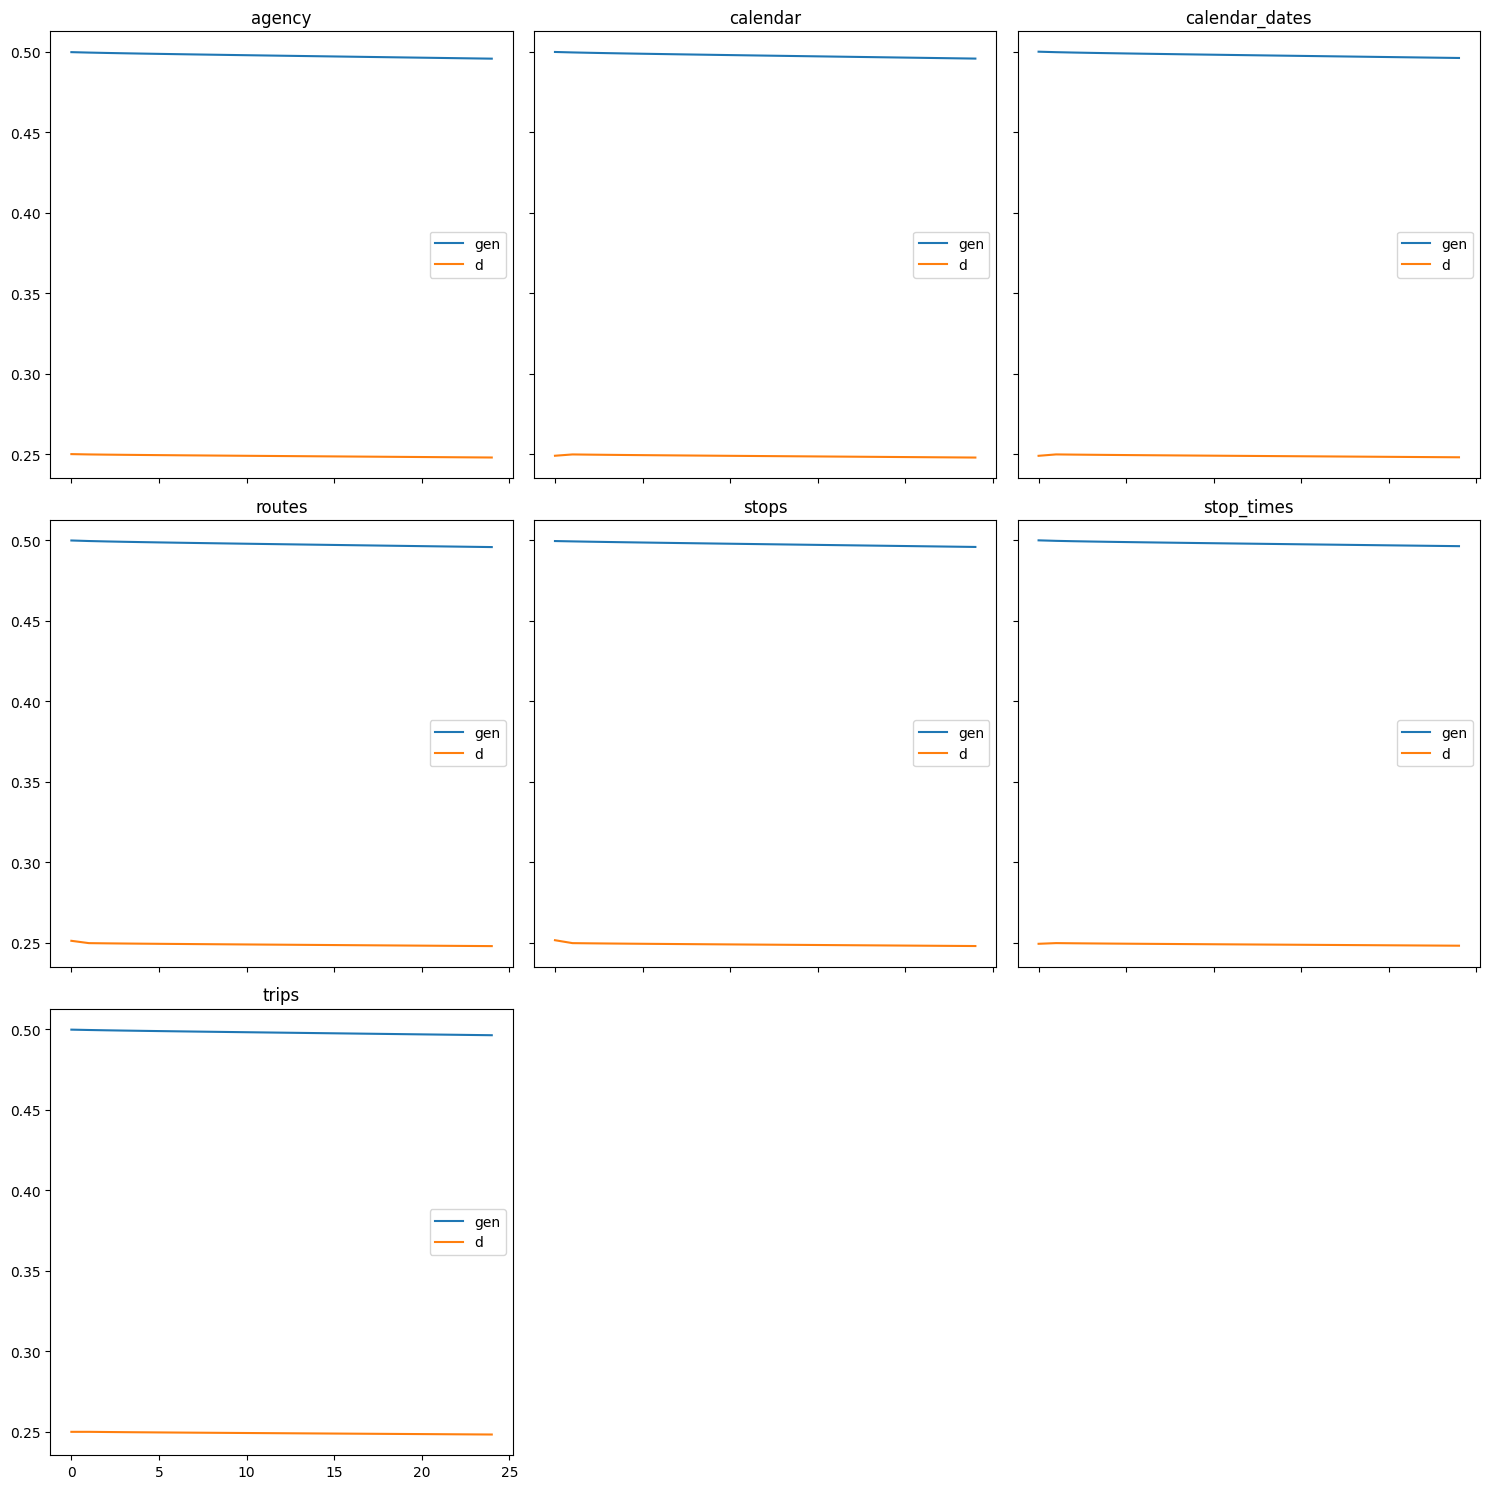

Total Time Used: 0m 39s


In [37]:
collection_training(processed_data_collection, training_parameter_dict)

# Synthetic Data Generation

In [38]:
# table_name:
# {'table':table, # df
#  'labels':labels, # df
#  'scaler':scaler, # a scaler object
#  'table_col_names':table_columns, # list of col names
#  'label_col_names':label_columns, # list of col names
#  'metadata':metadata[df_name]} # a metadata dict (see below)

# metadata
# {'primary_key':primary_key, # list, [column names, number_of_unique_ids]
#  'parent':parent, # dict, {parent_name:shared_id_column_name, ...}
#  'child':child} # str, child_name

In [39]:
# def generate_individual_synth_data(generator, labels, seed=123):
#     pass

In [40]:
def generate_synth_data_collection(processed_data_collection, generation_dict, latent_dim=100, seed=123):
    np.random.seed(seed)
    synthetic_data_collection = {}
    features_to_ignore_rounding = ['shape_pt_lat',
                      'shape_pt_lon',
                      'stop_lat',
                      'stop_lon',
                     'shape_dist_traveled']
    for df_name, content in processed_data_collection.items():
        generator = models.load_model('models/'+df_name+'_gan.h5')
        primary_key = content['metadata']['primary_key']
        child = content['metadata']['child']
        parent = content['metadata']['parent']
        fake_labels_df_dict = {}
        if primary_key != []:
            primary_key_col = primary_key[0]
            n_primary_keys = generation_dict[df_name]['nrows']
            fake_labels_df_dict[primary_key_col] = np.arange(n_primary_keys).tolist()
        if parent != {}:
            for parent_df_name, fr_key in parent.items():
                length = generation_dict[df_name]['nrows']
                parent_df = processed_data_collection[parent_df_name]
                kde = gaussian_kde(parent_df['labels'][fr_key].to_numpy())
                lower_bound = parent_df['labels'][fr_key].min()
                upper_bound = parent_df['labels'][fr_key].max()
                fake_array = kde.resample(length).flatten()
                fake_labels_df_dict[fr_key] = np.round(fake_array).clip(lower_bound, upper_bound).astype(int)
                # n_foreign_primary_keys = generation_dict[parent_df_name]['nrows']
                # length = generation_dict[df_name]['nrows']
                # fake_labels_df_dict[fr_key] = np.random.randint(0, n_foreign_primary_keys, length).tolist()
        fake_labels_df = pd.DataFrame(fake_labels_df_dict).reindex(columns=content['label_col_names'])
        # scaled_fake_labels_df = pd.DataFrame(content['labels_scaler'].transform(fake_labels_df), columns=content['label_col_names'])
        noise = np.random.uniform(0, 1, size=(generation_dict[df_name]['nrows'], latent_dim))
        raw_fake_table = generator.predict([noise, fake_labels_df])
        scaled_fake_table = content['table_scaler'].inverse_transform(raw_fake_table)
        fake_table_df = pd.DataFrame(scaled_fake_table, columns=content['table_col_names'])
        fake_data = pd.concat([fake_labels_df, fake_table_df], axis=1)
        
        columns_to_int = [col for col in fake_data.columns if col not in features_to_ignore_rounding]
        for col in columns_to_int:
            fake_data[col] = fake_data[col].round().astype(int)
                
        synthetic_data_collection[df_name] = fake_data
        
    return synthetic_data_collection

In [41]:
generation_dict = {k:{'nrows':len(v['table'])} for k,v in processed_data_collection.items()}

In [42]:
generation_dict

{'agency': {'nrows': 15},
 'calendar': {'nrows': 121},
 'calendar_dates': {'nrows': 674},
 'routes': {'nrows': 215},
 'stops': {'nrows': 6714},
 'stop_times': {'nrows': 966790},
 'trips': {'nrows': 32403}}

In [43]:
synthetic_data_collection = generate_synth_data_collection(processed_data_collection, generation_dict)

In [44]:
synthetic_data_collection

{'agency':     agency_id  agency_url  agency_timezone  agency_lang  agency_phone
 0           0           1                1            0             0
 1           1           1                1            0             0
 2           2           1                1            1             0
 3           3           1                1            0             0
 4           4           1                1            0             0
 5           5           1                1            0             1
 6           6           1                1            0             0
 7           7           1                1            1             1
 8           8           1                1            0             1
 9           9           1                1            1             1
 10         10           1                1            1             1
 11         11           1                1            1             1
 12         12           1                1            0           

# Metrics

## Pre-metrics Data Processing

In [45]:
def convert_to_dataframe_collection(processed_data_collection):
    new_dict = {}
    features_to_ignore_rounding = ['shape_pt_lat',
                      'shape_pt_lon',
                      'stop_lat',
                      'stop_lon',
                     'shape_dist_traveled']
    for df_name, content in processed_data_collection.items():
        table_scaler = content['table_scaler']
        labels = content['labels']
        table = content['table']
        table = pd.DataFrame(table_scaler.inverse_transform(table),columns = content['table_col_names'])
        new_df = pd.concat([labels, table], axis=1)
        columns_to_int = [col for col in new_df.columns if col not in features_to_ignore_rounding]
        for col in columns_to_int:
            new_df[col] = new_df[col].round().astype(int)
        new_dict[df_name] = new_df
    return new_dict

In [46]:
real_data_collection = convert_to_dataframe_collection(processed_data_collection)

In [47]:
real_data_collection
del processed_data_collection

### Cosine Similarity Test

In [48]:
def cos_test(fake_collection, real_collection):
    test_dict = {}
    for df_name in fake_collection.keys():
        mean_cos = []
        mean_cos.append(np.mean(metrics.pairwise.cosine_similarity(fake_collection[df_name].T, real_collection[df_name].T)))
        test_dict[df_name] = np.mean(mean_cos)
    return test_dict

In [49]:
cos_test(synthetic_data_collection, real_data_collection)

{'agency': 0.17197794196635313,
 'calendar': 0.49221033896169536,
 'calendar_dates': 0.8743835360396768,
 'routes': 0.3388447608237484,
 'stops': 0.21668188634574276,
 'stop_times': 0.5922777259531372,
 'trips': 0.5674423388415591}

### KS (Kolmogorov-Smirnov) Test

In [50]:
def batch_ks_test(fake_collection, real_collection):
    stats_dict = {}
    for df_name, fake_df in fake_collection.items():
        stats_list = []
        p_val_list = []
        test_dict = {}
        for col in fake_df.columns:
            stats, p_val = ks_2samp(fake_df[col], real_collection[df_name][col], alternative='two-sided', method='auto')
            stats_list.append(stats)
            p_val_list.append(p_val)
        test_dict['k_stats'] = np.mean(stats_list)
        test_dict['p_value'] = np.mean(p_val_list)
        stats_dict[df_name] = test_dict
    return stats_dict

In [51]:
batch_ks_test(synthetic_data_collection, real_data_collection)

{'agency': {'k_stats': 0.6, 'p_value': 0.23841440219002985},
 'calendar': {'k_stats': 0.40661157024793393, 'p_value': 0.20235676093758198},
 'calendar_dates': {'k_stats': 0.33283877349159247,
  'p_value': 9.956366016723962e-09},
 'routes': {'k_stats': 0.448062015503876, 'p_value': 0.31537658817611053},
 'stops': {'k_stats': 0.7413034124383544, 'p_value': 0.1111111111111111},
 'stop_times': {'k_stats': 0.6373051024524458, 'p_value': 0.0},
 'trips': {'k_stats': 0.4862319846927753, 'p_value': 0.125}}